In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Understanding the Data

This data is a Home Equity Line of Credit dataset used to predict if a potential borrower will default on their loan based on historical data.

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

# 2. Read in the Data

In [3]:
df = pd.read_csv('data/heloc_dataset_v1.csv', sep = ',')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.head()

RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0             Bad                    55                    144   
1             Bad                    61                     58   
2             Bad                    67                     66   
3             Bad                    66                    169   
4             Bad                    81                    333   

   MSinceMostRecentTradeOpen  AverageMInFile  NumSatisfactoryTrades  \
0                          4              84                     20   
1                         15              41                      2   
2                          5              24                      9   
3                          1              73                     28   
4                         27             132                     12   

   NumTrades60Ever2DerogPubRec  NumTrades90Ever2DerogPubRec  \
0                            3                            0   
1                            4                            4   
2                            0                            0   
3                            1                            1   
4                            0                            0   

   PercentTradesNeverDelq  MSinceMostRecentDelq  MaxDelq2PublicRecLast12M  \
0                      83                     2                         3   
1                     100                    -7                         0   
2                     100                    -7                         7   
3                      93                    76                         6   
4                     100                    -7                         7   

   MaxDelqEver  NumTotalTrades  NumTradesOpeninLast12M  PercentInstallTrades  \
0            5              23                       1                    43   
1            8               7                       0                    67   
2            8               9                       4                    44   
3            6              30                       3                    57   
4            8              12                       0                    25   

   MSinceMostRecentInqexcl7days  NumInqLast6M  NumInqLast6Mexcl7days  \
0                             0             0                      0   
1                             0             0                      0   
2                             0             4                      4   
3                             0             5                      4   
4                             0             1                      1   

   NetFractionRevolvingBurden  NetFractionInstallBurden  \
0                          33                        -8   
1                           0                        -8   
2                          53                        66   
3                          72                        83   
4                          51                        89   

   NumRevolvingTradesWBalance  NumInstallTradesWBalance  \
0                           8                         1   
1                           0                        -8   
2                           4                         2   
3                           6                         4   
4                           3                         1   

   NumBank2NatlTradesWHighUtilization  PercentTradesWBalance  
0                                   1                     69  
1                                  -8                      0  
2                                   1                     86  
3                                   3                     91  
4                                   0                     80

# 3. Understanding Features

In [6]:
df.columns

Index(['RiskPerformance', 'ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object')

These columns make sense. Standard metrics. The banking industry requires strong data if a bank is going to make determinations in addition to External Risk Estimate... which is your standard credit rating from a third party provider such as Experian etc.

<b>RiskPerformance:</b> Indicates the performance of the borrower in terms of loan repayment. 

<b>ExternalRiskEstimate:</b> An external estimate from another financial entity that predicts the probability of a borrower becoming past due in a certain time period.

<b>MSinceOldestTradeOpen:</b> The number of months since the borrower's oldest credit trade was opened.

<b>MSinceMostRecentTradeOpen:</b> The number of months since the borrower's most recent trade was opened.

<b>AverageMInFile:</b> Average number of months that the trades have been on file (or reported) for a specific borrower.

<b>NumSatisfactoryTrades:</b> The number of trades that are currently in "satisfactory" status.

<b>NumTrades60Ever2DerogPubRec:</b> The number of trades that have ever been 60 days or more delinquent or that led to a derogatory public record.

<b>NumTrades90Ever2DerogPubRec:</b> The number of trades that have ever been 90 days or more delinquent or that led to a derogatory public record.

<b>PercentTradesNeverDelq:</b> The percentage of all trades that have never been delinquent.

<b>MSinceMostRecentDelq:</b> Number of months since the most recent delinquency.

<b>MaxDelq2PublicRecLast12M:</b> The worst delinquency or public record in the last 12 months.

<b>MaxDelqEver:</b> The worst delinquency status the borrower has ever had.

<b>NumTotalTrades:</b> Total number of trades on the borrower's credit file.

<b>NumTradesOpeninLast12M:</b> Number of trades that were opened in the last 12 months.

<b>PercentInstallTrades:</b> Percentage of all trades that are installment trades.

<b>MSinceMostRecentInqexcl7days:</b> Months since the most recent inquiry, excluding the last 7 days.

<b>NumInqLast6M:</b> Number of inquiries on the borrower's credit file in the last 6 months.

<b>NumInqLast6Mexcl7days:</b> Number of inquiries on the borrower's credit file in the last 6 months, excluding the last 7 days.

<b>NetFractionRevolvingBurden:</b> This typically indicates the proportion of revolving trades  with a balance.

<b>NetFractionInstallBurden:</b> Similar to the above, but for installment trades.

<b>NumRevolvingTradesWBalance:</b> Number of revolving trades with a balance.

<b>NumInstallTradesWBalance:</b> Number of installment trades with a balance.

<b>NumBank2NatlTradesWHighUtilization:</b> Number of bank/national trades with high utilization.

<b>PercentTradesWBalance:</b> The percentage of all trades that currently have a balance.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

This data seems to be in really good shape. It was used for a FICO competition by real life machine learning engineerings from many banks accross the world. I am looking forward to taking a stab at this dataset.

In [8]:
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) > 10:  # If more than 10 unique values, show only the first 10.
        print(column, ":", unique_values[:10], "... and", len(unique_values) - 10, "more.")
    else:
        print(column, ":", unique_values)

RiskPerformance : ['Bad' 'Good']
ExternalRiskEstimate : [55 61 67 66 81 59 54 68 82 50] ... and 51 more.
MSinceOldestTradeOpen : [144  58  66 169 333 137  88 148 324  79] ... and 516 more.
MSinceMostRecentTradeOpen : [ 4 15  5  1 27 11  7  2 25  6] ... and 102 more.
AverageMInFile : [ 84  41  24  73 132  78  37  65 138  36] ... and 227 more.
NumSatisfactoryTrades : [20  2  9 28 12 31 25 17 24 19] ... and 64 more.
NumTrades60Ever2DerogPubRec : [ 3  4  0  1  2 -9  7  5 12  6] ... and 9 more.
NumTrades90Ever2DerogPubRec : [ 0  4  1  2  3 -9  5  9  7  6] ... and 7 more.
PercentTradesNeverDelq : [ 83 100  93  91  92  85  95  60  75  97] ... and 62 more.
MSinceMostRecentDelq : [ 2 -7 76  1  9 31  5 27 32  0] ... and 77 more.
MaxDelq2PublicRecLast12M : [ 3  0  7  6  4  5 -9  9  1  2]
MaxDelqEver : [ 5  8  6  4  2 -9  3  7]
NumTotalTrades : [23  7  9 30 12 32 26 18 27 19] ... and 78 more.
NumTradesOpeninLast12M : [ 1  0  4  3  2  5 -9  8  6  7] ... and 9 more.
PercentInstallTrades : [43 67 44 

# 4. Understanding the Business Case

The business use case of this is to create a model that can predict if a borrower will default based on the data provided here. The target output will be RiskPerformance feature.

# 5. Engineering Features

In [9]:
# Updating RiskPerformance for correlation matrix. Bad is 1 and Good is 0, this way we are predicting if someone will be bad or not since this is a Risk business case.
df['RiskPerformance'] = df['RiskPerformance'].replace({'Bad': 1, 'Good': 0})

In [10]:
correlation_matrix = df.corr()

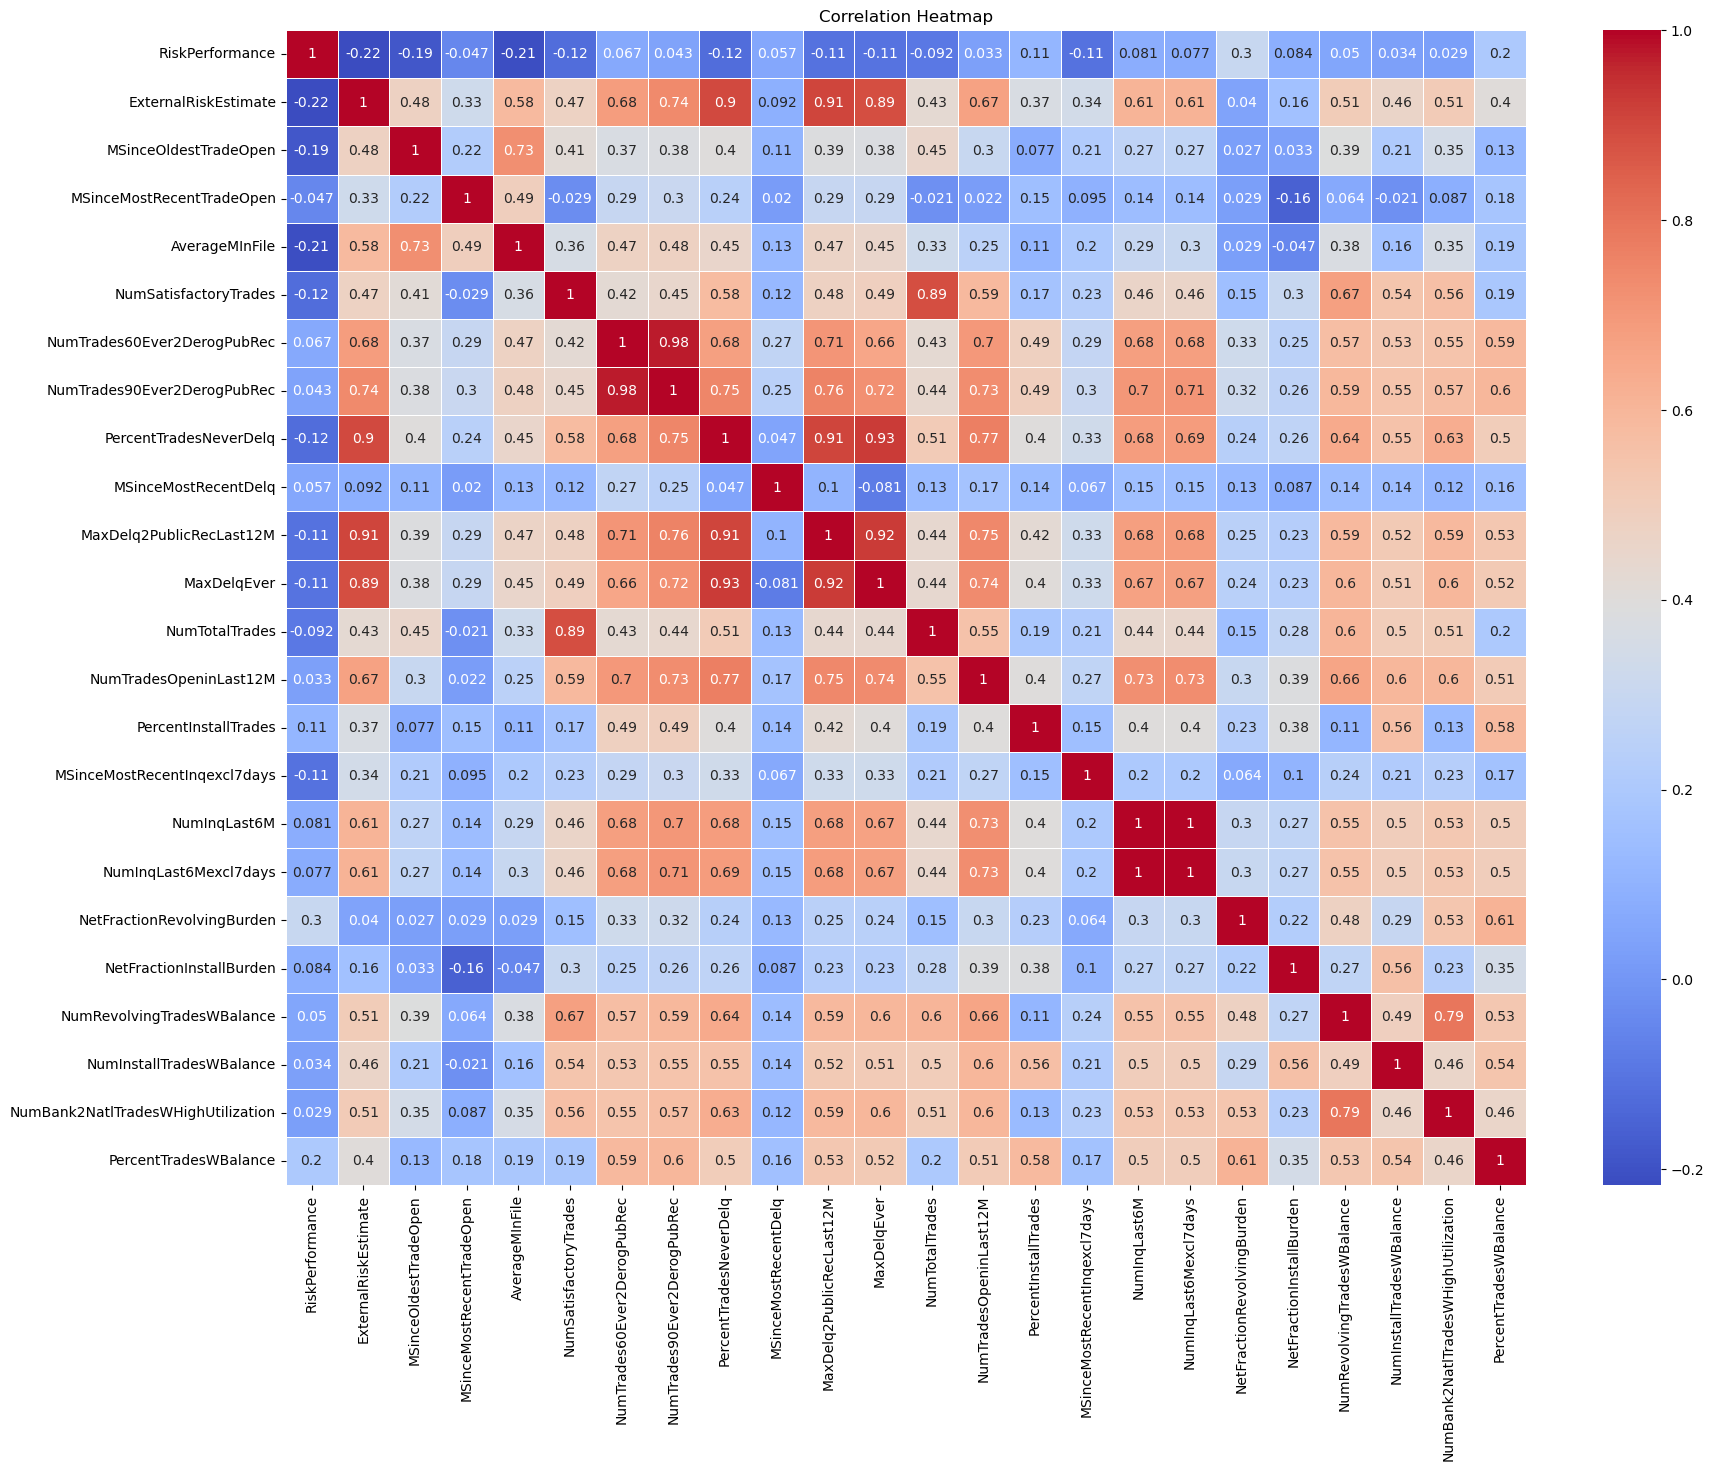

In [11]:
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
column_order = correlation_matrix.abs().sum().sort_values(ascending=False).index

In [13]:
ordered_corr_matrix = correlation_matrix.loc[column_order, column_order]

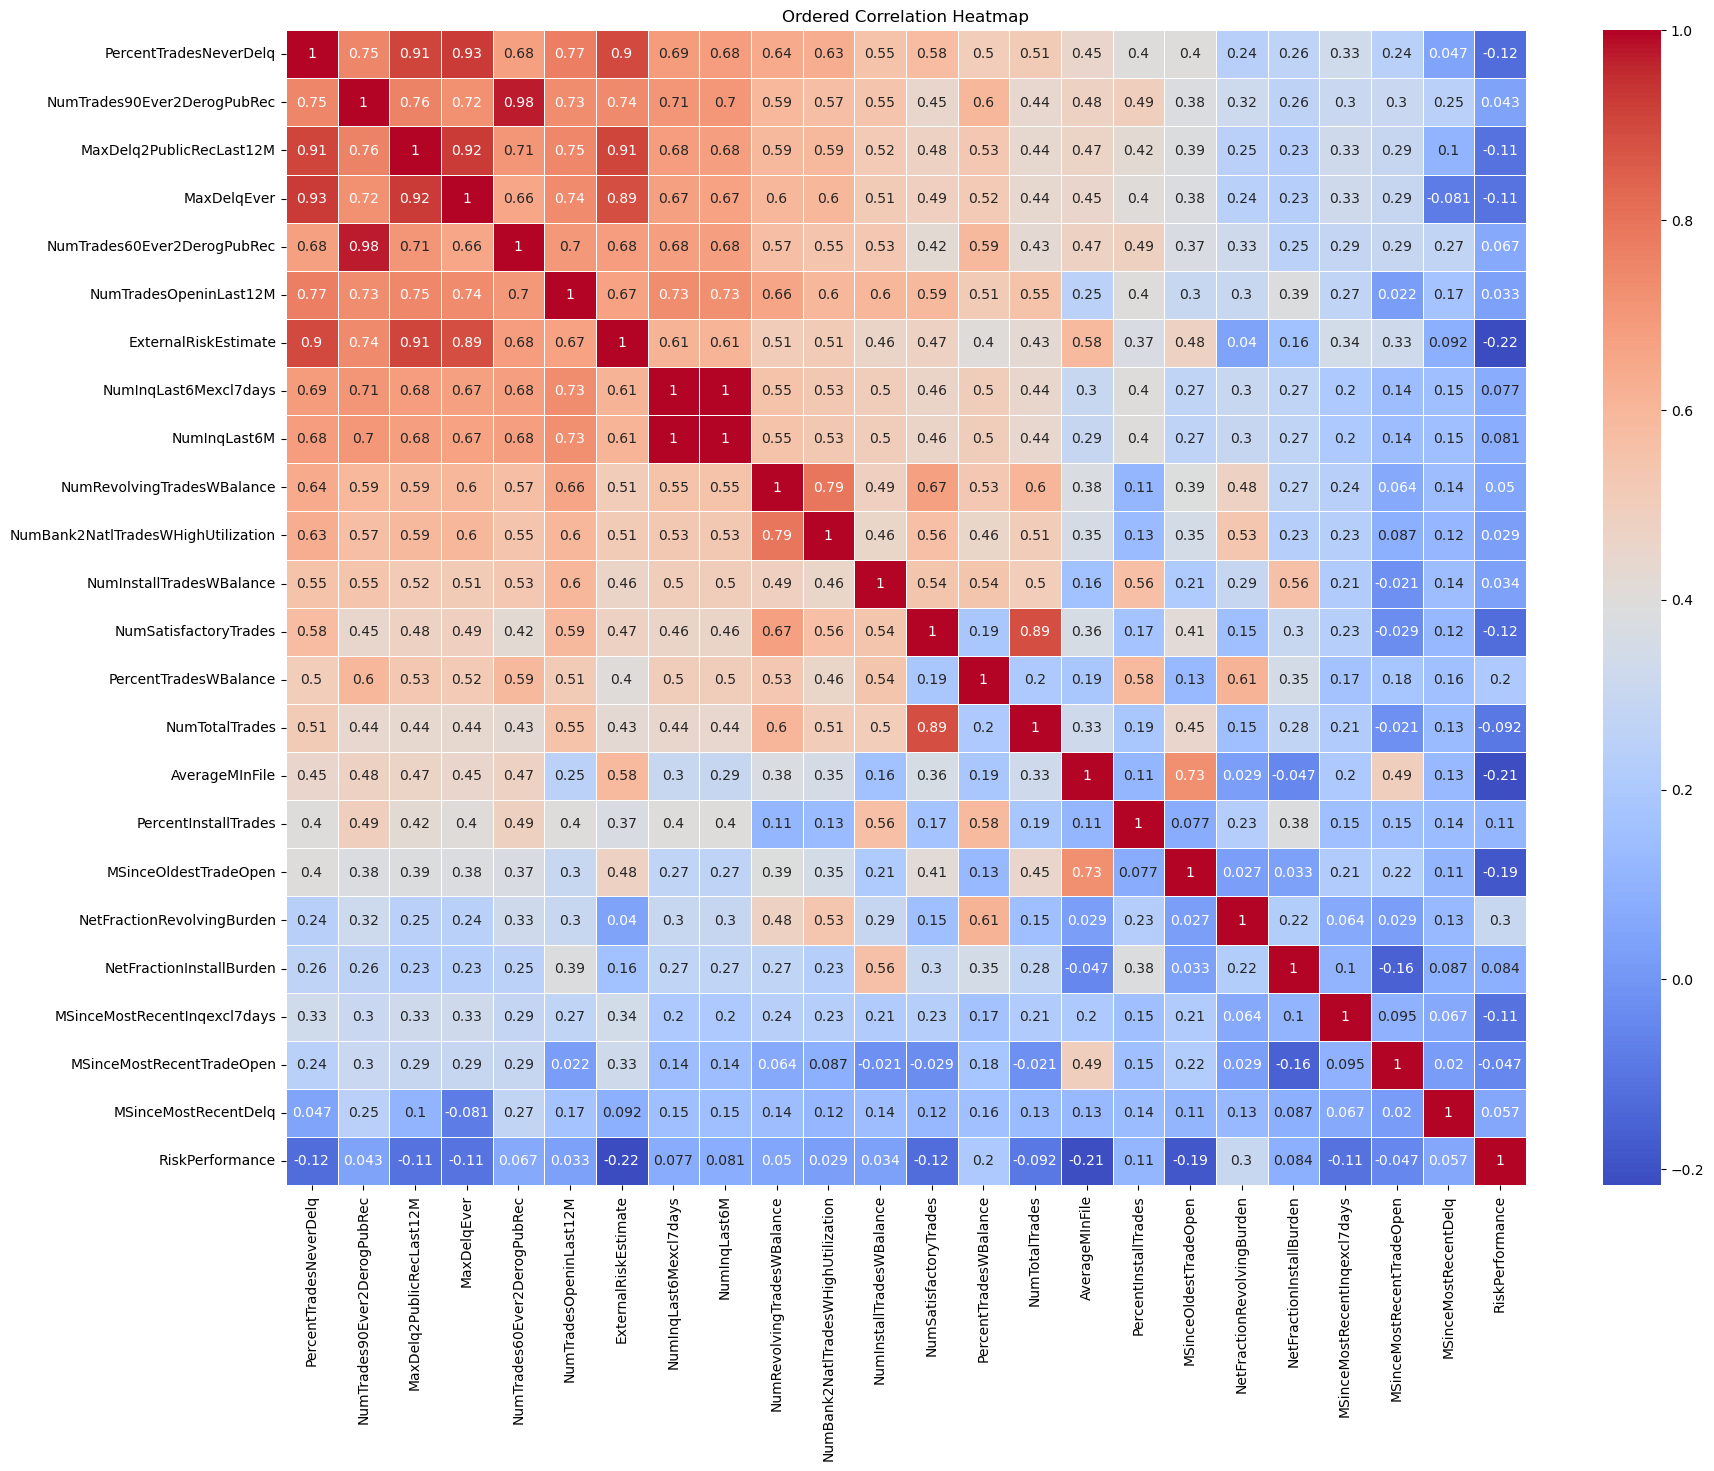

In [14]:
plt.figure(figsize=(20, 15))
sns.heatmap(ordered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ordered Correlation Heatmap')
plt.show()

In [15]:
risk_performance_corr = correlation_matrix['RiskPerformance'].sort_values(ascending=False)

In [16]:
risk_performance_corr

RiskPerformance                       1.000000
NetFractionRevolvingBurden            0.298174
PercentTradesWBalance                 0.198554
PercentInstallTrades                  0.111542
NetFractionInstallBurden              0.083645
NumInqLast6M                          0.080964
NumInqLast6Mexcl7days                 0.076660
NumTrades60Ever2DerogPubRec           0.067211
MSinceMostRecentDelq                  0.057067
NumRevolvingTradesWBalance            0.050099
NumTrades90Ever2DerogPubRec           0.043402
NumInstallTradesWBalance              0.034337
NumTradesOpeninLast12M                0.032649
NumBank2NatlTradesWHighUtilization    0.029091
MSinceMostRecentTradeOpen            -0.046937
NumTotalTrades                       -0.091504
MaxDelqEver                          -0.107204
MaxDelq2PublicRecLast12M             -0.109946
MSinceMostRecentInqexcl7days         -0.110253
PercentTradesNeverDelq               -0.122010
NumSatisfactoryTrades                -0.123080
MSinceOldestT

What is interestsing here is we really don't have a very clear linear relationship with one or two features. It is interesting to understand that a higher External Risk Estimate value means a stronger credit position and lower risk. It's good to keep that in mind. I am going to re-order this list based on absolute value.

In [17]:
risk_performance_corr = risk_performance_corr.abs().sort_values(ascending=False)


In [18]:
risk_performance_corr

RiskPerformance                       1.000000
NetFractionRevolvingBurden            0.298174
ExternalRiskEstimate                  0.216770
AverageMInFile                        0.209168
PercentTradesWBalance                 0.198554
MSinceOldestTradeOpen                 0.185155
NumSatisfactoryTrades                 0.123080
PercentTradesNeverDelq                0.122010
PercentInstallTrades                  0.111542
MSinceMostRecentInqexcl7days          0.110253
MaxDelq2PublicRecLast12M              0.109946
MaxDelqEver                           0.107204
NumTotalTrades                        0.091504
NetFractionInstallBurden              0.083645
NumInqLast6M                          0.080964
NumInqLast6Mexcl7days                 0.076660
NumTrades60Ever2DerogPubRec           0.067211
MSinceMostRecentDelq                  0.057067
NumRevolvingTradesWBalance            0.050099
MSinceMostRecentTradeOpen             0.046937
NumTrades90Ever2DerogPubRec           0.043402
NumInstallTra

In [19]:
df_target = df['RiskPerformance']

In [20]:
df_heloc = df.drop('RiskPerformance',axis=1)

In [21]:
df_heloc.columns

Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object')

I'm going to limit the columns to any that have a correlation of .1 or higher from the risk_performance_corr. This was a good guideline for my Practical Assignment 3 so I'm going to start here to see what models may work best and find an even better coefficient ranking of the the features.

In [22]:
relevant_columns = risk_performance_corr[risk_performance_corr.abs() >= 0.1].index


In [23]:
relevant_columns = [col for col in relevant_columns if col != 'RiskPerformance']
df_heloc_filtered = df_heloc[relevant_columns]


# 6. Test/Train Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_heloc_filtered, df_target, test_size=0.2, random_state=42)

In [25]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8367, 11)
X_test shape: (2092, 11)
y_train shape: (8367,)
y_test shape: (2092,)


# 7. Baseline Model

In [26]:
counts = y_train.value_counts()
count_0 = counts.get(0, 0)
count_1 = counts.get(1, 0) 

print(f"Number of 0s: {count_0}")
print(f"Number of 1s: {count_1}")


Number of 0s: 3996
Number of 1s: 4371


Calculating how often 1 or Bad is in the Risk Performance y_train data.

In [27]:
4371 / (3996+4371)

0.5224094657583364

Appears that 52% of the time, we have a bad credit performance per the dataset.

In [28]:
majority_class = y_train.value_counts().idxmax()

In [29]:
baseline_accuracy = (y_test == majority_class).mean()

In [30]:
print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.5200764818355641


This matches very closely to how often a bad rating is in the data. Let's see what we can do from here.

# 8. Simple Model

Common industry standard from credit risk is to use Logisitic Regression. I am interested to see how the other model types fair. Let's setup a simple model here.

In [31]:
logreg = LogisticRegression()

In [32]:
logreg.fit(X_train, y_train)

/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
y_pred = logreg.predict(X_test)

In [34]:
accuracy = (y_pred == y_test).mean()

# 9. Score the Model

In [35]:
print("Accuracy:", accuracy)

Accuracy: 0.6615678776290631


In [36]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [37]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6615678776290631
Precision: 0.6756007393715342
Recall: 0.671875
F1 Score: 0.6737327188940092


**Interpreting these results**: Precision here tells us that when our model or bank believes someone is a good borrorwer that they are. High Precision will reduce defaults. A strong Recall score will ensure the bank is making money by not too highly rejecting loans to otherwise good borrowers.

In [38]:
confusion_matrix = confusion_matrix(y_test, y_pred)

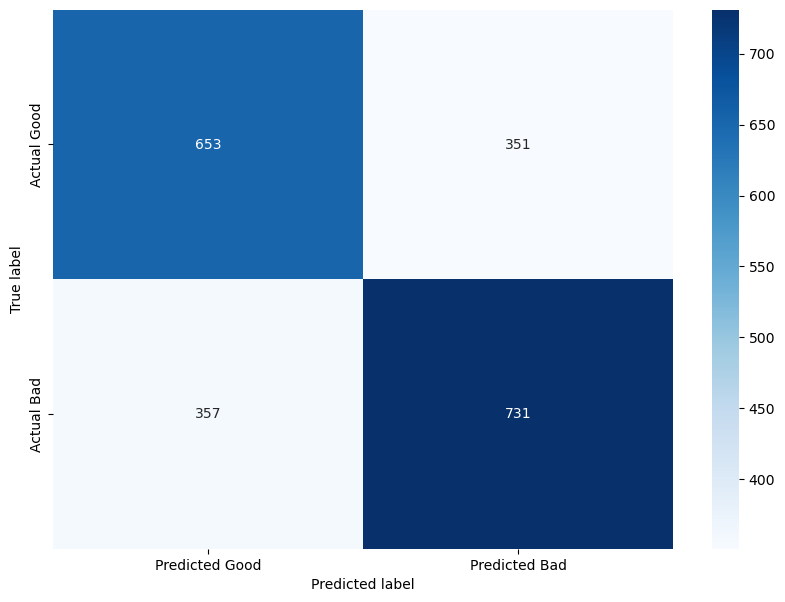

In [39]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'], 
            yticklabels=['Actual Good', 'Actual Bad'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
cm_percentage = confusion_matrix / confusion_matrix.sum() * 100


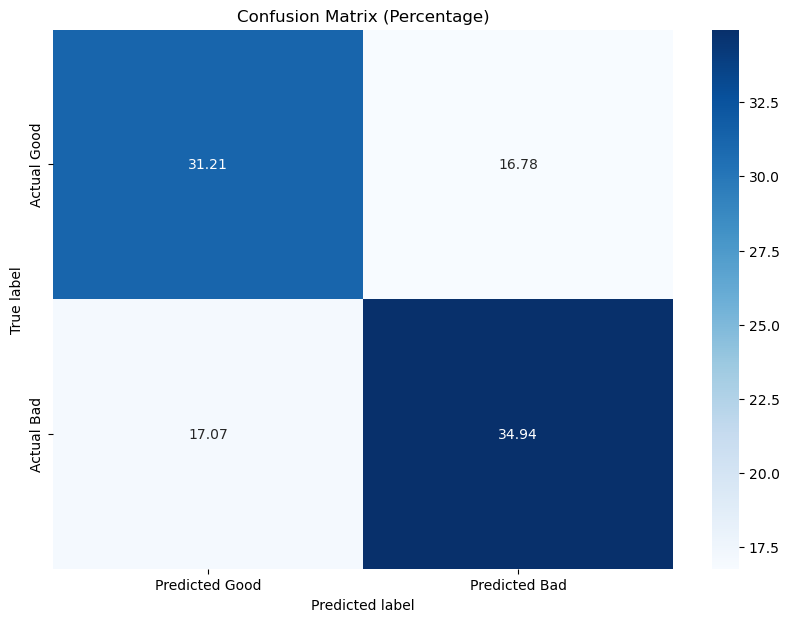

In [41]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'], 
            yticklabels=['Actual Good', 'Actual Bad'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (Percentage)')
plt.show()

**True Positive**: (Top left quadrant)The model predicts the applicant will be a good borrower (not default), and they actually don't default.

**False Positive**: (Top right quadrant) The model predicts the applicant will be a good borrower, but they default. This is risky for the bank as it ends up lending to a borrower who then defaults.

**True Negative**:  (Bottom right quadrant) The model predicts the applicant will default (be a bad borrower), and they do. This is the scenario where the bank avoids potential bad loans.

**False Negative**: (Bottom left quadrant) The model predicts the applicant will default, but they do not. This is a lost opportunity for the bank because it incorrectly denied a loan to a good borrower from whom it could have earned interest.

# 10. Model Comparisons

In [42]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000), 
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True)
}

In [43]:
model_names = []
model_params = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []

In [44]:
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Precision
    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)
    
    # Recall
    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)
    
    # F1 Score
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # AUC
    train_pred_prob = model.predict_proba(X_train)[:, 1] 
    test_pred_prob = model.predict_proba(X_test)[:, 1]
    train_auc = roc_auc_score(y_train, train_pred_prob)
    test_auc = roc_auc_score(y_test, test_pred_prob)
    
    model_params.append(model.get_params())
    model_names.append(model_name)
    train_times.append(train_time)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

In [45]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params
})

In [46]:
results_df

Model  Train Time  Train Accuracy  Test Accuracy  \
0  Logistic Regression    0.183528        0.696665       0.665870   
1                  KNN    0.006571        0.770647       0.648662   
2        Decision Tree    0.057472        0.975140       0.610421   
3                  SVM   15.641268        0.725469       0.695029   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.703621        0.678604      0.724548     0.679228        0.713931   
1         0.768389        0.653345      0.803020     0.691176        0.785323   
2         0.954575        0.618593      1.000000     0.654412        0.976760   
3         0.718776        0.691327      0.779456     0.747243        0.747887   

   Test F1 Score  Train AUC  Test AUC  \
0       0.678916   0.754952  0.722895   
1       0.671728   0.850963  0.694525   
2       0.635998   0.998428  0.615301   
3       0.718198   0.789322  0.754114   

                                          Parameters  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  
1  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
2  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
3  {'C': 1.0, 'break_ties': False, 'cache_size': ...

Let's see what some more advanced models do.

In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [48]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'GBM': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000)
}

In [49]:
model_names = []
model_params = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []

In [50]:
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Precision
    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)
    
    # Recall
    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)
    
    # F1 Score
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # AUC
    train_pred_prob = model.predict_proba(X_train)[:, 1] 
    test_pred_prob = model.predict_proba(X_test)[:, 1]  
    train_auc = roc_auc_score(y_train, train_pred_prob)
    test_auc = roc_auc_score(y_test, test_pred_prob)
    
    model_params.append(model.get_params())
    model_names.append(model_name)
    train_times.append(train_time)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

In [51]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params
})

In [52]:
results_df

Model  Train Time  Train Accuracy  Test Accuracy  \
0  Logistic Regression    0.281904        0.696665       0.665870   
1                  KNN    0.008493        0.770647       0.648662   
2        Decision Tree    0.042841        0.975140       0.610899   
3                  SVM   13.875853        0.725469       0.695029   
4        Random Forest    1.003186        0.975140       0.697419   
5                  GBM    0.821382        0.750448       0.706023   
6             AdaBoost    0.236780        0.732999       0.708891   
7              XGBoost    0.211607        0.909286       0.695985   
8          Extra Trees    0.693147        0.975140       0.695985   
9       Neural Network    1.882855        0.717700       0.672084   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.703621        0.678604      0.724548     0.679228        0.713931   
1         0.768389        0.653345      0.803020     0.691176        0.785323   
2         0.954575        0.618718      1.000000     0.656250        0.976760   
3         0.718776        0.691327      0.779456     0.747243        0.747887   
4         0.954575        0.694278      1.000000     0.747243        0.976760   
5         0.739660        0.703704      0.805994     0.750919        0.771404   
6         0.730131        0.708442      0.775566     0.748162        0.752163   
7         0.894495        0.695502      0.936857     0.738971        0.915186   
8         0.954575        0.697552      1.000000     0.733456        0.976760   
9         0.735191        0.689623      0.718371     0.671875        0.726684   

   Test F1 Score  Train AUC  Test AUC  \
0       0.678916   0.754952  0.722895   
1       0.671728   0.850963  0.694525   
2       0.636931   0.998428  0.615747   
3       0.718198   0.789323  0.754108   
4       0.719788   0.998416  0.762711   
5       0.726545   0.831056  0.776554   
6       0.727760   0.806517  0.772814   
7       0.716578   0.977069  0.753325   
8       0.715054   0.998428  0.758242   
9       0.680633   0.795070  0.738992   

                                          Parameters  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  
1  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
2  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
3  {'C': 1.0, 'break_ties': False, 'cache_size': ...  
4  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
5  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
6  {'algorithm': 'SAMME.R', 'base_estimator': Non...  
7  {'objective': 'binary:logistic', 'use_label_en...  
8  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...  
9  {'activation': 'relu', 'alpha': 0.0001, 'batch...

In [53]:
results_df_accuracy = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
results_df_precision = results_df.sort_values(by="Test Precision", ascending=False).reset_index(drop=True)
results_df_recall = results_df.sort_values(by="Test Recall", ascending=False).reset_index(drop=True)
results_df_f1 = results_df.sort_values(by="Test F1 Score", ascending=False).reset_index(drop=True)


In [54]:
results_df_accuracy

Model  Train Time  Train Accuracy  Test Accuracy  \
0             AdaBoost    0.236780        0.732999       0.708891   
1                  GBM    0.821382        0.750448       0.706023   
2        Random Forest    1.003186        0.975140       0.697419   
3              XGBoost    0.211607        0.909286       0.695985   
4          Extra Trees    0.693147        0.975140       0.695985   
5                  SVM   13.875853        0.725469       0.695029   
6       Neural Network    1.882855        0.717700       0.672084   
7  Logistic Regression    0.281904        0.696665       0.665870   
8                  KNN    0.008493        0.770647       0.648662   
9        Decision Tree    0.042841        0.975140       0.610899   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.730131        0.708442      0.775566     0.748162        0.752163   
1         0.739660        0.703704      0.805994     0.750919        0.771404   
2         0.954575        0.694278      1.000000     0.747243        0.976760   
3         0.894495        0.695502      0.936857     0.738971        0.915186   
4         0.954575        0.697552      1.000000     0.733456        0.976760   
5         0.718776        0.691327      0.779456     0.747243        0.747887   
6         0.735191        0.689623      0.718371     0.671875        0.726684   
7         0.703621        0.678604      0.724548     0.679228        0.713931   
8         0.768389        0.653345      0.803020     0.691176        0.785323   
9         0.954575        0.618718      1.000000     0.656250        0.976760   

   Test F1 Score  Train AUC  Test AUC  \
0       0.727760   0.806517  0.772814   
1       0.726545   0.831056  0.776554   
2       0.719788   0.998416  0.762711   
3       0.716578   0.977069  0.753325   
4       0.715054   0.998428  0.758242   
5       0.718198   0.789323  0.754108   
6       0.680633   0.795070  0.738992   
7       0.678916   0.754952  0.722895   
8       0.671728   0.850963  0.694525   
9       0.636931   0.998428  0.615747   

                                          Parameters  
0  {'algorithm': 'SAMME.R', 'base_estimator': Non...  
1  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
2  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
3  {'objective': 'binary:logistic', 'use_label_en...  
4  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...  
5  {'C': 1.0, 'break_ties': False, 'cache_size': ...  
6  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
7  {'C': 1.0, 'class_weight': None, 'dual': False...  
8  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
9  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...

In [55]:
results_df_precision

Model  Train Time  Train Accuracy  Test Accuracy  \
0             AdaBoost    0.236780        0.732999       0.708891   
1                  GBM    0.821382        0.750448       0.706023   
2          Extra Trees    0.693147        0.975140       0.695985   
3              XGBoost    0.211607        0.909286       0.695985   
4        Random Forest    1.003186        0.975140       0.697419   
5                  SVM   13.875853        0.725469       0.695029   
6       Neural Network    1.882855        0.717700       0.672084   
7  Logistic Regression    0.281904        0.696665       0.665870   
8                  KNN    0.008493        0.770647       0.648662   
9        Decision Tree    0.042841        0.975140       0.610899   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.730131        0.708442      0.775566     0.748162        0.752163   
1         0.739660        0.703704      0.805994     0.750919        0.771404   
2         0.954575        0.697552      1.000000     0.733456        0.976760   
3         0.894495        0.695502      0.936857     0.738971        0.915186   
4         0.954575        0.694278      1.000000     0.747243        0.976760   
5         0.718776        0.691327      0.779456     0.747243        0.747887   
6         0.735191        0.689623      0.718371     0.671875        0.726684   
7         0.703621        0.678604      0.724548     0.679228        0.713931   
8         0.768389        0.653345      0.803020     0.691176        0.785323   
9         0.954575        0.618718      1.000000     0.656250        0.976760   

   Test F1 Score  Train AUC  Test AUC  \
0       0.727760   0.806517  0.772814   
1       0.726545   0.831056  0.776554   
2       0.715054   0.998428  0.758242   
3       0.716578   0.977069  0.753325   
4       0.719788   0.998416  0.762711   
5       0.718198   0.789323  0.754108   
6       0.680633   0.795070  0.738992   
7       0.678916   0.754952  0.722895   
8       0.671728   0.850963  0.694525   
9       0.636931   0.998428  0.615747   

                                          Parameters  
0  {'algorithm': 'SAMME.R', 'base_estimator': Non...  
1  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
2  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...  
3  {'objective': 'binary:logistic', 'use_label_en...  
4  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
5  {'C': 1.0, 'break_ties': False, 'cache_size': ...  
6  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
7  {'C': 1.0, 'class_weight': None, 'dual': False...  
8  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
9  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...

In [56]:
results_df_recall

Model  Train Time  Train Accuracy  Test Accuracy  \
0                  GBM    0.821382        0.750448       0.706023   
1             AdaBoost    0.236780        0.732999       0.708891   
2                  SVM   13.875853        0.725469       0.695029   
3        Random Forest    1.003186        0.975140       0.697419   
4              XGBoost    0.211607        0.909286       0.695985   
5          Extra Trees    0.693147        0.975140       0.695985   
6                  KNN    0.008493        0.770647       0.648662   
7  Logistic Regression    0.281904        0.696665       0.665870   
8       Neural Network    1.882855        0.717700       0.672084   
9        Decision Tree    0.042841        0.975140       0.610899   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.739660        0.703704      0.805994     0.750919        0.771404   
1         0.730131        0.708442      0.775566     0.748162        0.752163   
2         0.718776        0.691327      0.779456     0.747243        0.747887   
3         0.954575        0.694278      1.000000     0.747243        0.976760   
4         0.894495        0.695502      0.936857     0.738971        0.915186   
5         0.954575        0.697552      1.000000     0.733456        0.976760   
6         0.768389        0.653345      0.803020     0.691176        0.785323   
7         0.703621        0.678604      0.724548     0.679228        0.713931   
8         0.735191        0.689623      0.718371     0.671875        0.726684   
9         0.954575        0.618718      1.000000     0.656250        0.976760   

   Test F1 Score  Train AUC  Test AUC  \
0       0.726545   0.831056  0.776554   
1       0.727760   0.806517  0.772814   
2       0.718198   0.789323  0.754108   
3       0.719788   0.998416  0.762711   
4       0.716578   0.977069  0.753325   
5       0.715054   0.998428  0.758242   
6       0.671728   0.850963  0.694525   
7       0.678916   0.754952  0.722895   
8       0.680633   0.795070  0.738992   
9       0.636931   0.998428  0.615747   

                                          Parameters  
0  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
1  {'algorithm': 'SAMME.R', 'base_estimator': Non...  
2  {'C': 1.0, 'break_ties': False, 'cache_size': ...  
3  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
4  {'objective': 'binary:logistic', 'use_label_en...  
5  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...  
6  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
7  {'C': 1.0, 'class_weight': None, 'dual': False...  
8  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
9  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...

In [57]:
results_df_f1

Model  Train Time  Train Accuracy  Test Accuracy  \
0             AdaBoost    0.236780        0.732999       0.708891   
1                  GBM    0.821382        0.750448       0.706023   
2        Random Forest    1.003186        0.975140       0.697419   
3                  SVM   13.875853        0.725469       0.695029   
4              XGBoost    0.211607        0.909286       0.695985   
5          Extra Trees    0.693147        0.975140       0.695985   
6       Neural Network    1.882855        0.717700       0.672084   
7  Logistic Regression    0.281904        0.696665       0.665870   
8                  KNN    0.008493        0.770647       0.648662   
9        Decision Tree    0.042841        0.975140       0.610899   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.730131        0.708442      0.775566     0.748162        0.752163   
1         0.739660        0.703704      0.805994     0.750919        0.771404   
2         0.954575        0.694278      1.000000     0.747243        0.976760   
3         0.718776        0.691327      0.779456     0.747243        0.747887   
4         0.894495        0.695502      0.936857     0.738971        0.915186   
5         0.954575        0.697552      1.000000     0.733456        0.976760   
6         0.735191        0.689623      0.718371     0.671875        0.726684   
7         0.703621        0.678604      0.724548     0.679228        0.713931   
8         0.768389        0.653345      0.803020     0.691176        0.785323   
9         0.954575        0.618718      1.000000     0.656250        0.976760   

   Test F1 Score  Train AUC  Test AUC  \
0       0.727760   0.806517  0.772814   
1       0.726545   0.831056  0.776554   
2       0.719788   0.998416  0.762711   
3       0.718198   0.789323  0.754108   
4       0.716578   0.977069  0.753325   
5       0.715054   0.998428  0.758242   
6       0.680633   0.795070  0.738992   
7       0.678916   0.754952  0.722895   
8       0.671728   0.850963  0.694525   
9       0.636931   0.998428  0.615747   

                                          Parameters  
0  {'algorithm': 'SAMME.R', 'base_estimator': Non...  
1  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
2  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
3  {'C': 1.0, 'break_ties': False, 'cache_size': ...  
4  {'objective': 'binary:logistic', 'use_label_en...  
5  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...  
6  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
7  {'C': 1.0, 'class_weight': None, 'dual': False...  
8  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
9  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...

I'm going to create a simple heuristic that determines if a model is overfit or not so what we are not making any false conclusions here before we start hyper parameter tuning.

We will say that a difference in Train and Test Accuracy of 5% or less is an acceptable percentage difference and we will not consider that a sign of overfitting. Between 5-10% difference will be mild overfitting. Between 10-20% we will consider this moderate overfitting, and above 20% would be gross overfitting.

In [58]:
def overfitting_category(train, test):
    difference = abs(train - test)
    
    if 0 <= difference < 0.05:
        return 'Acceptable'
    elif 0.05 <= difference < 0.10:
        return 'Mild Overfitting'
    elif 0.10 <= difference < 0.20:
        return 'Moderate Overfitting'
    else:
        return 'Gross Overfitting'

In [59]:
results_df_precision['Accuracy Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train Accuracy'], row['Test Accuracy']), axis=1)
results_df_precision['Precision Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train Precision'], row['Test Precision']), axis=1)
results_df_precision['Recall Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train Recall'], row['Test Recall']), axis=1)
results_df_precision['F1 Score Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train F1 Score'], row['Test F1 Score']), axis=1)
results_df_precision['AUC Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train AUC'], row['Test AUC']), axis=1)

In [60]:
results_df_precision[['Model', 'Accuracy Overfitting', 'Precision Overfitting', 'Recall Overfitting', 'F1 Score Overfitting', 'AUC Overfitting']]

Model  Accuracy Overfitting Precision Overfitting  \
0             AdaBoost            Acceptable            Acceptable   
1                  GBM            Acceptable            Acceptable   
2          Extra Trees     Gross Overfitting     Gross Overfitting   
3              XGBoost            Acceptable            Acceptable   
4        Random Forest     Gross Overfitting  Moderate Overfitting   
5                  SVM     Gross Overfitting     Gross Overfitting   
6       Neural Network            Acceptable            Acceptable   
7  Logistic Regression            Acceptable            Acceptable   
8                  KNN  Moderate Overfitting  Moderate Overfitting   
9        Decision Tree     Gross Overfitting     Gross Overfitting   

     Recall Overfitting  F1 Score Overfitting       AUC Overfitting  
0            Acceptable            Acceptable            Acceptable  
1      Mild Overfitting            Acceptable      Mild Overfitting  
2     Gross Overfitting     Gross Overfitting     Gross Overfitting  
3            Acceptable            Acceptable            Acceptable  
4  Moderate Overfitting  Moderate Overfitting     Gross Overfitting  
5     Gross Overfitting     Gross Overfitting     Gross Overfitting  
6            Acceptable            Acceptable      Mild Overfitting  
7            Acceptable            Acceptable            Acceptable  
8  Moderate Overfitting  Moderate Overfitting  Moderate Overfitting  
9     Gross Overfitting     Gross Overfitting     Gross Overfitting

In [61]:
results_df_precision

Model  Train Time  Train Accuracy  Test Accuracy  \
0             AdaBoost    0.236780        0.732999       0.708891   
1                  GBM    0.821382        0.750448       0.706023   
2          Extra Trees    0.693147        0.975140       0.695985   
3              XGBoost    0.211607        0.909286       0.695985   
4        Random Forest    1.003186        0.975140       0.697419   
5                  SVM   13.875853        0.725469       0.695029   
6       Neural Network    1.882855        0.717700       0.672084   
7  Logistic Regression    0.281904        0.696665       0.665870   
8                  KNN    0.008493        0.770647       0.648662   
9        Decision Tree    0.042841        0.975140       0.610899   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.730131        0.708442      0.775566     0.748162        0.752163   
1         0.739660        0.703704      0.805994     0.750919        0.771404   
2         0.954575        0.697552      1.000000     0.733456        0.976760   
3         0.894495        0.695502      0.936857     0.738971        0.915186   
4         0.954575        0.694278      1.000000     0.747243        0.976760   
5         0.718776        0.691327      0.779456     0.747243        0.747887   
6         0.735191        0.689623      0.718371     0.671875        0.726684   
7         0.703621        0.678604      0.724548     0.679228        0.713931   
8         0.768389        0.653345      0.803020     0.691176        0.785323   
9         0.954575        0.618718      1.000000     0.656250        0.976760   

   Test F1 Score  Train AUC  Test AUC  \
0       0.727760   0.806517  0.772814   
1       0.726545   0.831056  0.776554   
2       0.715054   0.998428  0.758242   
3       0.716578   0.977069  0.753325   
4       0.719788   0.998416  0.762711   
5       0.718198   0.789323  0.754108   
6       0.680633   0.795070  0.738992   
7       0.678916   0.754952  0.722895   
8       0.671728   0.850963  0.694525   
9       0.636931   0.998428  0.615747   

                                          Parameters  Accuracy Overfitting  \
0  {'algorithm': 'SAMME.R', 'base_estimator': Non...            Acceptable   
1  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...            Acceptable   
2  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...     Gross Overfitting   
3  {'objective': 'binary:logistic', 'use_label_en...            Acceptable   
4  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...     Gross Overfitting   
5  {'C': 1.0, 'break_ties': False, 'cache_size': ...     Gross Overfitting   
6  {'activation': 'relu', 'alpha': 0.0001, 'batch...            Acceptable   
7  {'C': 1.0, 'class_weight': None, 'dual': False...            Acceptable   
8  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  Moderate Overfitting   
9  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...     Gross Overfitting   

  Precision Overfitting    Recall Overfitting  F1 Score Overfitting  \
0            Acceptable            Acceptable            Acceptable   
1            Acceptable      Mild Overfitting            Acceptable   
2     Gross Overfitting     Gross Overfitting     Gross Overfitting   
3            Acceptable            Acceptable            Acceptable   
4  Moderate Overfitting  Moderate Overfitting  Moderate Overfitting   
5     Gross Overfitting     Gross Overfitting     Gross Overfitting   
6            Acceptable            Acceptable            Acceptable   
7            Acceptable            Acceptable            Acceptable   
8  Moderate Overfitting  Moderate Overfitting  Moderate Overfitting   
9     Gross Overfitting     Gross Overfitting     Gross Overfitting   

        AUC Overfitting  
0            Acceptable  
1      Mild Overfitting  
2     Gross Overfitting  
3            Acceptable  
4     Gross Overfitting  
5     Gross Overfitting  
6      Mild Overfitting  
7            Acceptable  
8  Moderate Overfitting  
9     Gross 

In [62]:
cols_to_drop = [col for col in results_df_precision.columns if "Train" in col]
results_df_precision = results_df_precision.drop(columns=cols_to_drop)

In [63]:
results_df_precision

Model  Test Accuracy  Test Precision  Test Recall  \
0             AdaBoost       0.708891        0.708442     0.748162   
1                  GBM       0.706023        0.703704     0.750919   
2          Extra Trees       0.695985        0.697552     0.733456   
3              XGBoost       0.695985        0.695502     0.738971   
4        Random Forest       0.697419        0.694278     0.747243   
5                  SVM       0.695029        0.691327     0.747243   
6       Neural Network       0.672084        0.689623     0.671875   
7  Logistic Regression       0.665870        0.678604     0.679228   
8                  KNN       0.648662        0.653345     0.691176   
9        Decision Tree       0.610899        0.618718     0.656250   

   Test F1 Score  Test AUC                                         Parameters  \
0       0.727760  0.772814  {'algorithm': 'SAMME.R', 'base_estimator': Non...   
1       0.726545  0.776554  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...   
2       0.715054  0.758242  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...   
3       0.716578  0.753325  {'objective': 'binary:logistic', 'use_label_en...   
4       0.719788  0.762711  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   
5       0.718198  0.754108  {'C': 1.0, 'break_ties': False, 'cache_size': ...   
6       0.680633  0.738992  {'activation': 'relu', 'alpha': 0.0001, 'batch...   
7       0.678916  0.722895  {'C': 1.0, 'class_weight': None, 'dual': False...   
8       0.671728  0.694525  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
9       0.636931  0.615747  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   

   Accuracy Overfitting Precision Overfitting    Recall Overfitting  \
0            Acceptable            Acceptable            Acceptable   
1            Acceptable            Acceptable      Mild Overfitting   
2     Gross Overfitting     Gross Overfitting     Gross Overfitting   
3            Acceptable            Acceptable            Acceptable   
4     Gross Overfitting  Moderate Overfitting  Moderate Overfitting   
5     Gross Overfitting     Gross Overfitting     Gross Overfitting   
6            Acceptable            Acceptable            Acceptable   
7            Acceptable            Acceptable            Acceptable   
8  Moderate Overfitting  Moderate Overfitting  Moderate Overfitting   
9     Gross Overfitting     Gross Overfitting     Gross Overfitting   

   F1 Score Overfitting       AUC Overfitting  
0            Acceptable            Acceptable  
1            Acceptable      Mild Overfitting  
2     Gross Overfitting     Gross Overfitting  
3            Acceptable            Acceptable  
4  Moderate Overfitting     Gross Overfitting  
5     Gross Overfitting     Gross Overfitting  
6            Acceptable      Mild Overfitting  
7            Acceptable            Acceptable  
8  Moderate Overfitting  Moderate Overfitting  
9     Gross Overfitting     Gross Overfitting

I want to move forward with AdaBoost, XGBoost, Logisitic Regression and Neural Networks. These all do not have overfitting issues (acceptable for all catageories), and still have strong viable accuracy, precision, recall, and F1 scores.

# 11. Model Optimization

## AdaBoostClassifer

In [64]:
ada = AdaBoostClassifier(random_state=42)

In [65]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0, 2.0],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [None, 42]
}

We are going to optimize for precision score because this is what causes the worst expected loss.

In [66]:
scorer = make_scorer(precision_score)

In [67]:
grid_obj = GridSearchCV(ada, params, scoring=scorer, cv=5)

In [68]:
grid_fit = grid_obj.fit(X_train, y_train)

/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-pack

In [69]:
best_ada = grid_fit.best_estimator_

In [70]:
best_params = grid_fit.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}


In [71]:
cv_results = pd.DataFrame(grid_fit.cv_results_)

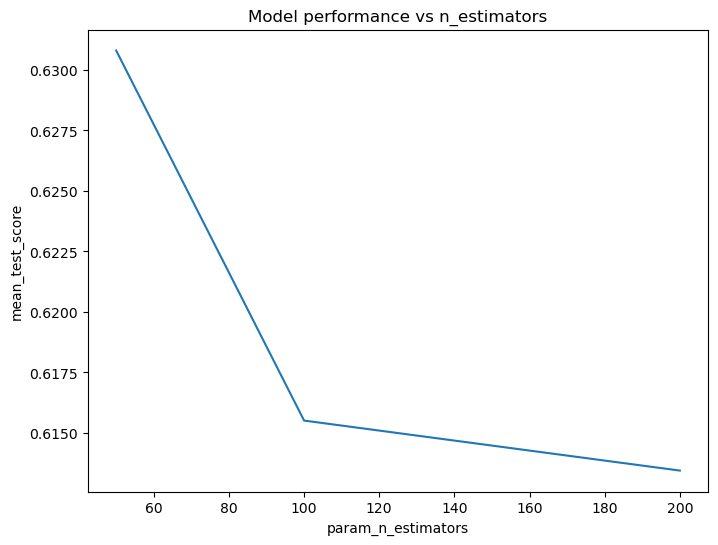

In [72]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=cv_results, x='param_n_estimators', y='mean_test_score', ci=None)
plt.title('Model performance vs n_estimators')
plt.show()

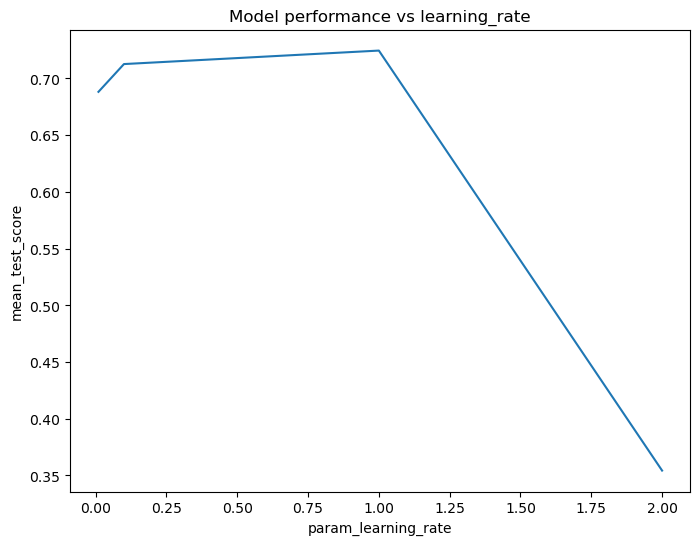

In [73]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=cv_results, x='param_learning_rate', y='mean_test_score', ci=None)
plt.title('Model performance vs learning_rate')
plt.show()

Apply parameters to model and see results of the optimized model.

In [77]:
def train_model(model, params, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    start_time = time.time()
    model.set_params(**params)
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_prec = precision_score(y_train, y_train_pred, average='macro')
    test_prec = precision_score(y_test, y_test_pred, average='macro')

    train_recall = recall_score(y_train, y_train_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')

    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)

    overfit_category = overfitting_category(train_acc, test_acc)

    return model.__class__.__name__, train_time, train_acc, test_acc, train_prec, test_prec, train_recall, test_recall, train_f1, test_f1, train_auc, test_auc, params, overfit_category

In [78]:
model_names = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = [] 
model_params = []
overfit_categories = []

In [79]:
results = train_model(best_ada, best_params, X_train, y_train)
model_names.append(results[0])
train_times.append(results[1])
train_accuracies.append(results[2])
test_accuracies.append(results[3])
train_precisions.append(results[4])
test_precisions.append(results[5])
train_recalls.append(results[6])
test_recalls.append(results[7])
train_f1s.append(results[8])
test_f1s.append(results[9])
train_aucs.append(results[10])
test_aucs.append(results[11])
model_params.append(results[12])
overfit_categories.append(results[13])

In [80]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params,
    'Overfitting Category': overfit_categories
})

In [81]:
results_df

Model  Train Time  Train Accuracy  Test Accuracy  \
0  AdaBoostClassifier    0.488957        0.729568       0.744325   

   Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  \
0         0.729763        0.746554      0.727505     0.742068        0.727907   

   Test F1 Score  Train AUC  Test AUC  \
0       0.742311    0.80921  0.818072   

                                          Parameters Overfitting Category  
0  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...           Acceptable

## XGBoost

In [82]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,7],
    'min_child_weight': [1, 3],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators' : [100, 200],
    'objective': ['binary:logistic']
}

In [83]:
grid = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, verbose=3, n_jobs=-1, cv=5)


In [84]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [85]:
best_xgb = grid.best_estimator_

In [86]:
best_params = grid.best_params_

In [87]:
best_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'subsample': 0.7}

In [88]:
model_names = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []
model_params = []
overfit_categories = []

In [89]:
results = train_model(best_xgb, best_params, X_train, y_train)
model_names.append(results[0])
train_times.append(results[1])
train_accuracies.append(results[2])
test_accuracies.append(results[3])
train_precisions.append(results[4])
test_precisions.append(results[5])
train_recalls.append(results[6])
test_recalls.append(results[7])
train_f1s.append(results[8])
test_f1s.append(results[9])
train_aucs.append(results[10]) 
test_aucs.append(results[11]) 
model_params.append(results[12])
overfit_categories.append(results[13])

In [90]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params,
    'Overfitting Category': overfit_categories
})

In [91]:
results_df

Model  Train Time  Train Accuracy  Test Accuracy  Train Precision  \
0  XGBClassifier    0.165879        0.748842       0.746714         0.749652   

   Test Precision  Train Recall  Test Recall  Train F1 Score  Test F1 Score  \
0        0.748991      0.746562     0.744461        0.747071       0.744719   

   Train AUC  Test AUC                                         Parameters  \
0   0.828389  0.818583  {'colsample_bytree': 0.7, 'learning_rate': 0.1...   

  Overfitting Category  
0           Acceptable

Let's optimize n_estimators

In [92]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [93]:
num_boost_round = best_params.pop('n_estimators')

In [94]:
cv_results = xgb.cv(dtrain=dtrain, params=best_params, nfold=3, 
                    num_boost_round=num_boost_round, 
                    early_stopping_rounds=10, metrics="error", 
                    as_pandas=True, seed=123)

In [95]:
n_best_trees = cv_results.shape[0]

In [96]:
print(f"Best number of trees: {n_best_trees}")

Best number of trees: 76


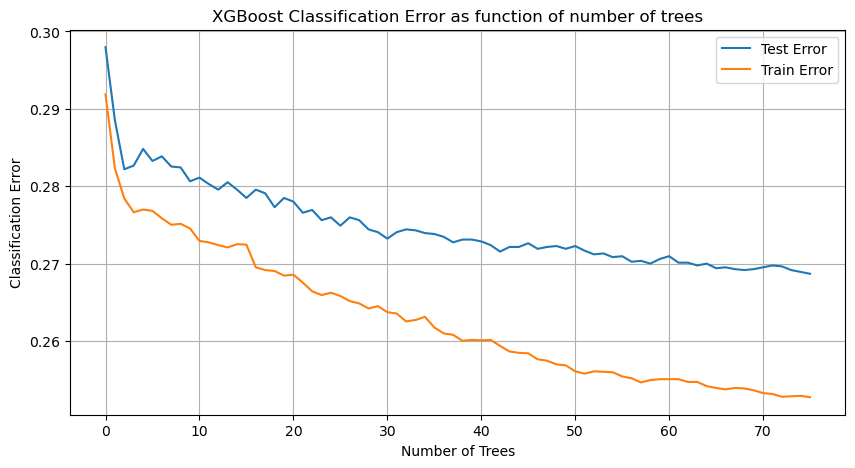

In [97]:
plt.figure(figsize=(10,5))
plt.plot(cv_results.index, cv_results["test-error-mean"], label='Test Error')
plt.plot(cv_results.index, cv_results["train-error-mean"], label='Train Error')
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error as function of number of trees')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,7],
    'min_child_weight': [1, 3],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators' : range(50, 201, 10),
    'objective': ['binary:logistic']
}

In [99]:
grid = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, verbose=3, n_jobs=-1, cv=5)

In [100]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [101]:
best_params = grid.best_params_

In [102]:
best_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 130,
 'objective': 'binary:logistic',
 'subsample': 0.7}

In [103]:
best_xgb = grid.best_estimator_

In [104]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=130, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [105]:
from sklearn.model_selection import cross_val_score

In [106]:
train_scores = []
test_scores = []

In [107]:
n_estimators_range = range(50, 201, 10)

Creating a visual of the n_estimators from 50-201 by every 10 to show how we chose the correct n estimators

In [108]:
for n in n_estimators_range:
    model = xgb.XGBClassifier(
        colsample_bytree=0.7,
        learning_rate=0.01,
        max_depth=7,
        min_child_weight=3,
        n_estimators=n,
        objective='binary:logistic',
        subsample=0.7,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    train_cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    train_scores.append(np.mean(train_cv_scores))
    
    test_cv_scores = cross_val_score(model, X_test, y_test, cv=5)
    test_scores.append(np.mean(test_cv_scores))

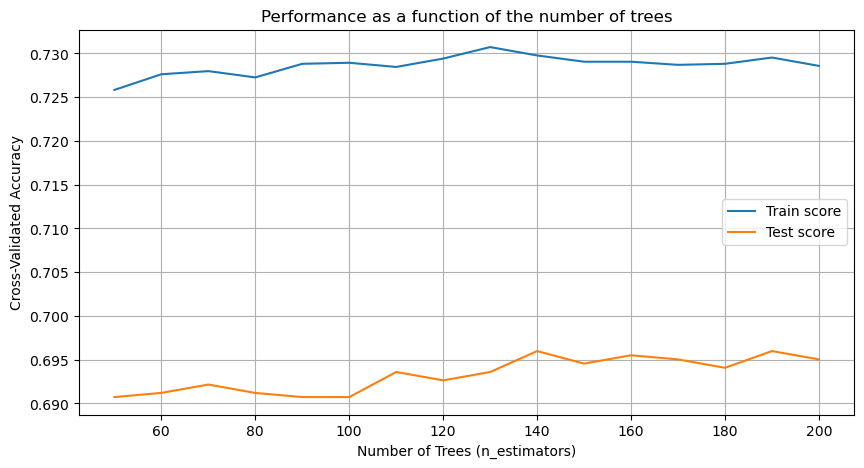

In [109]:
plt.figure(figsize=(10,5))
plt.plot(n_estimators_range, train_scores, label='Train score')
plt.plot(n_estimators_range, test_scores, label='Test score')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Performance as a function of the number of trees')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
model_names = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []
model_params = []
overfit_categories = []

In [111]:
results = train_model(best_xgb, best_params, X_train, y_train)
model_names.append(results[0])
train_times.append(results[1])
train_accuracies.append(results[2])
test_accuracies.append(results[3])
train_precisions.append(results[4])
test_precisions.append(results[5])
train_recalls.append(results[6])
test_recalls.append(results[7])
train_f1s.append(results[8])
test_f1s.append(results[9])
train_aucs.append(results[10])
test_aucs.append(results[11])
model_params.append(results[12])
overfit_categories.append(results[13])

In [112]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params,
    'Overfitting Category': overfit_categories
})

In [113]:
results_df

Model  Train Time  Train Accuracy  Test Accuracy  Train Precision  \
0  XGBClassifier    0.355085        0.772001       0.741338         0.773635   

   Test Precision  Train Recall  Test Recall  Train F1 Score  Test F1 Score  \
0        0.743568      0.769526     0.739055        0.770184       0.739273   

   Train AUC  Test AUC                                         Parameters  \
0   0.857176  0.815527  {'colsample_bytree': 0.7, 'learning_rate': 0.0...   

  Overfitting Category  
0           Acceptable

We have optimized this very well.

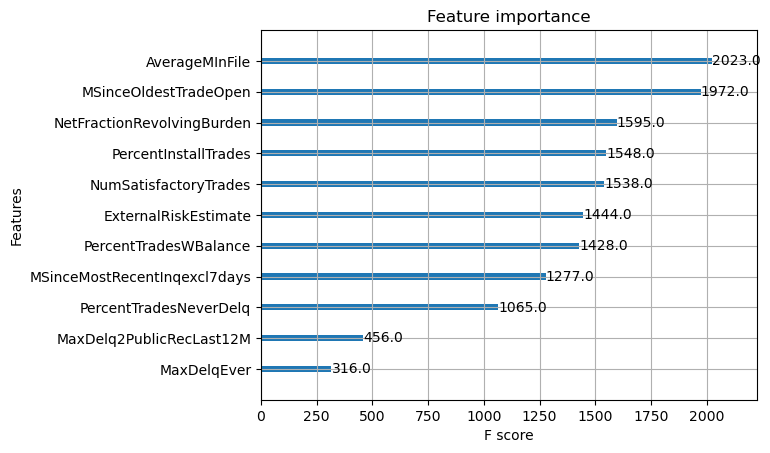

In [114]:
xgb.plot_importance(model)
plt.show()

In [115]:
from sklearn.inspection import plot_partial_dependence

In [116]:
features = [0]

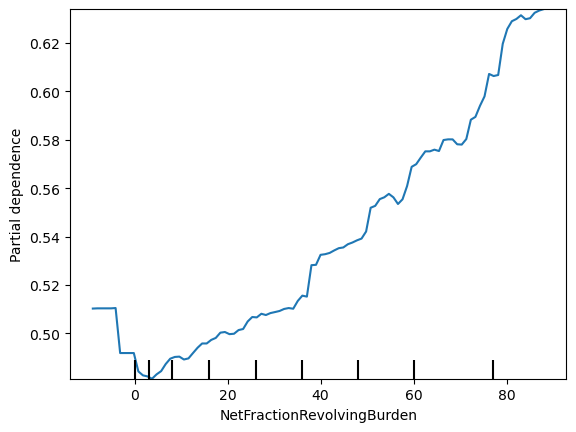

In [117]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [118]:
features = [1]

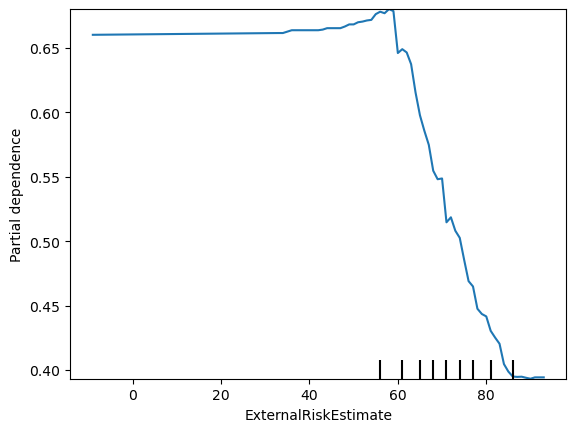

In [119]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [120]:
features = [2]

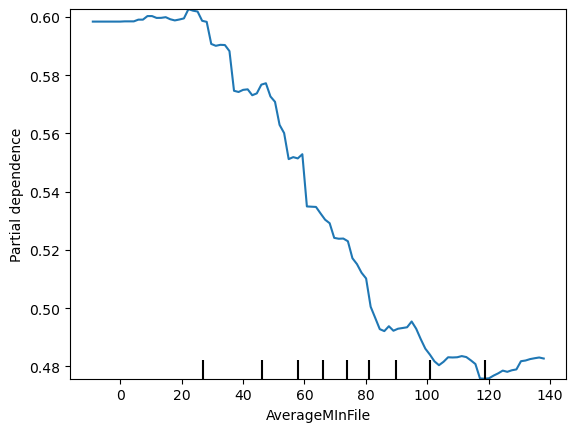

In [121]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [122]:
features = [3]

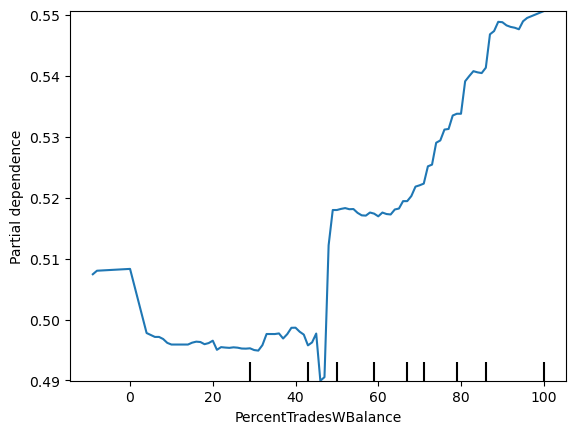

In [123]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [124]:
features = [4]

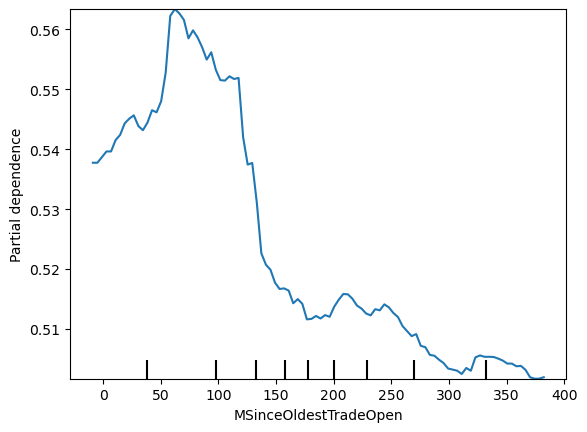

In [125]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [126]:
features = [5]

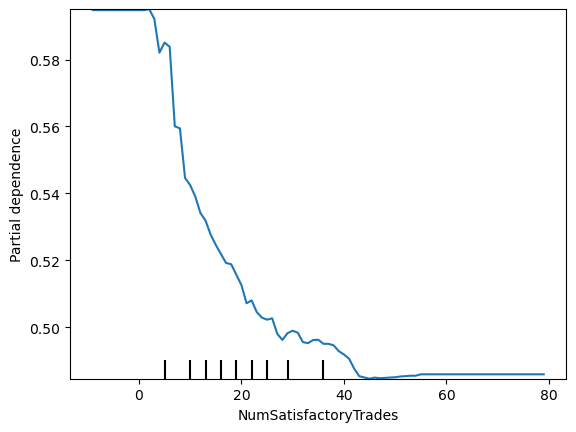

In [127]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [128]:
features = [6]

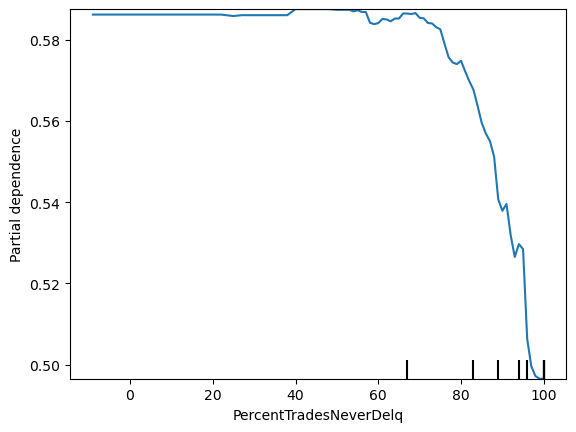

In [129]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [130]:
features = [7]

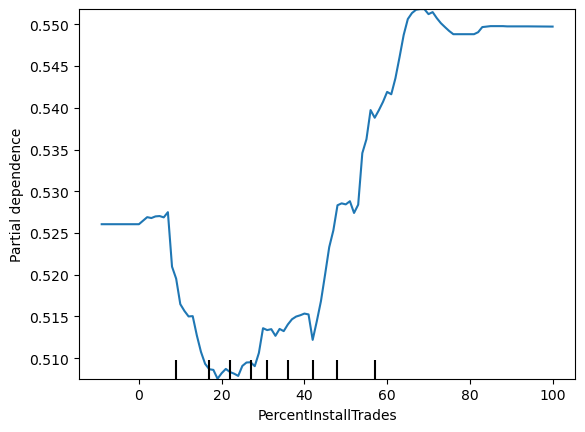

In [131]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [132]:
features = [8]

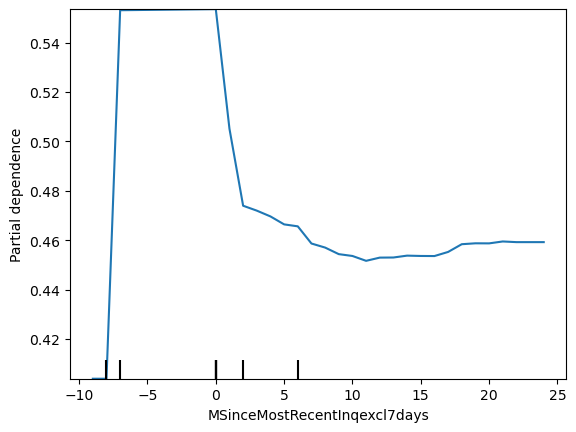

In [133]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [134]:
features = [9]

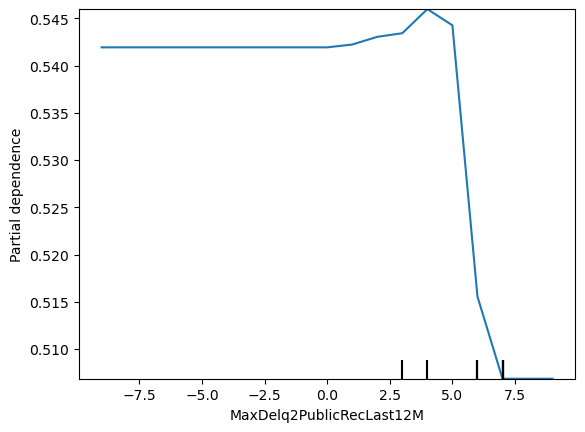

In [135]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [136]:
features = [10]

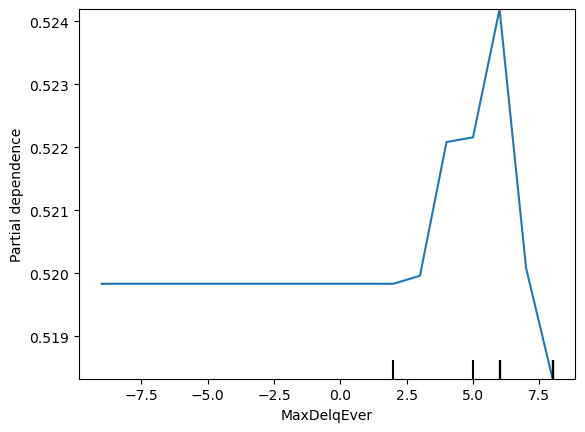

In [137]:
plot_partial_dependence(model, X_train, features)
plt.show()

## Logistic Regression

In [138]:
param_grid = {
    'C': [0.00001,0.0001,0.001, 0.01],
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000]
}

In [139]:
logistic = LogisticRegression()

In [140]:
grid_search = GridSearchCV(estimator = logistic, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [141]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vic

/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vic

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01], 'max_iter': [1000],
                         'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=2)

In [142]:
grid_search.best_params_

{'C': 1e-05, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}

In [143]:
param_grid = {'C': [0.00001,0.0001,0.001, 0.01, 0.1, 1],
             'max_iter': [1000]}

In [144]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [145]:
for metric in scorers.keys():
    print(f"Optimizing for {metric}:")
    
    grid = GridSearchCV(LogisticRegression(), param_grid, scoring=scorers[metric], cv=5)
    grid.fit(X_train, y_train)
    
    print(f"  Best score: {grid.best_score_}")
    print(f"  Best params: {grid.best_params_}\n")

Optimizing for accuracy:
  Best score: 0.6959465857697739
  Best params: {'C': 0.1, 'max_iter': 1000}

Optimizing for precision:
  Best score: 0.7031063716540682
  Best params: {'C': 0.1, 'max_iter': 1000}

Optimizing for recall:
  Best score: 0.7238600849950965
  Best params: {'C': 0.1, 'max_iter': 1000}

Optimizing for f1:
  Best score: 0.7132107925834492
  Best params: {'C': 0.1, 'max_iter': 1000}



In [146]:
model = LogisticRegression(C=0.1, max_iter= 1000)

In [147]:
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000)

In [148]:
y_train_pred = model.predict(X_train)

In [149]:
y_test_pred = model.predict(X_test)

In [151]:
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

In [152]:
train_auc = roc_auc_score(y_train, y_train_prob)

In [153]:
test_auc = roc_auc_score(y_test, y_test_prob)

In [154]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

In [155]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [156]:
print(f"Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}")
print(f"Train precision: {train_precision}, Test precision: {test_precision}")
print(f"Train recall: {train_recall}, Test recall: {test_recall}")
print(f"Train F1: {train_f1}, Test F1: {test_f1}")
print(f"Train AUC: {train_auc}, Test AUC: {test_auc}")

Train accuracy: 0.6966654714951596, Test accuracy: 0.6658699808795411
Train precision: 0.7036214174627861, Test precision: 0.6786042240587695
Train recall: 0.7245481583161748, Test recall: 0.6792279411764706
Train F1: 0.7139314697926059, Test F1: 0.6789159393661001
Train AUC: 0.7549276570095604, Test AUC: 0.7228974726095617


It doesn't appear that tuning this model is making much of a difference. It's scores are also not as competitive with XGBoost and Adaboost models. I'm going to move on to Neural Network tuning.

## Neural Network

In [157]:
nn_row = results_df_precision[results_df_precision['Model'] == 'Neural Network']

In [158]:
nn_params = nn_row['Parameters'].values[0]

In [159]:
nn_params

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Going to hyper parameter tune learning rate first. I also am focusing on optimizing based on precision. I will check for overfitting/underfitting after.

In [160]:
from sklearn.neural_network import MLPClassifier

In [161]:
mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    batch_size='auto',
    beta_1=0.9,
    beta_2=0.999,
    early_stopping=False,
    epsilon=1e-08,
    hidden_layer_sizes=(100,),
    learning_rate='constant',
    max_fun=15000,
    max_iter=1000,
    momentum=0.9,
    n_iter_no_change=10,
    nesterovs_momentum=True,
    power_t=0.5,
    random_state=None,
    shuffle=True,
    solver='adam',
    tol=0.0001,
    validation_fraction=0.1,
    verbose=False,
    warm_start=False
)

In [162]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]

In [163]:
param_grid = {'learning_rate_init': learning_rates}

In [164]:
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='precision')

In [165]:
grid_search.fit(X_train, y_train)

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.718 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.718 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.751 total time=   1.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.730 total time=   2.1s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.701 total time=   1.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.712 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.714 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.724 total time=   2.1s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.730 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.746 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=20

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.741 total time=   0.5s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.745 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.729 total time=   2.1s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.737 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.722 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=20

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=50, objective=binary:logistic, subsample=0.7;, score=0.741 total time=   0.2s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=60, objective=binary:logistic, subsample=0.7;, score=0.714 total time=   0.3s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=70, objective=binary:logistic, subsample=0.7;, score=0.708 total time=   0.4s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=90, objective=binary:logistic, subsample=0.7;, score=0.720 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=120, objective=binary:logistic, subsample=0.7;, score=0.742 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=140

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.741 total time=   0.5s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.714 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.713 total time=   2.1s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.718 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.740 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=20

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.715 total time=   0.5s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.719 total time=   0.5s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.726 total time=   2.1s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.722 total time=   0.4s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.723 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=10

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.745 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.749 total time=   1.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.727 total time=   1.1s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.749 total time=   0.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.731 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=20

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.717 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.750 total time=   2.1s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.725 total time=   0.4s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.723 total time=   0.4s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.720 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
             param_grid={'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]},
             scoring='precision')

In [166]:
best_learning_rate = grid_search.best_params_['learning_rate_init']
best_model = grid_search.best_estimator_

In [167]:
best_learning_rate

0.1

In [168]:
best_model

MLPClassifier(learning_rate_init=0.1, max_iter=1000)

In [169]:
best_model.fit(X_train, y_train)

MLPClassifier(learning_rate_init=0.1, max_iter=1000)

In [170]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [171]:
y_train_prob = best_model.predict_proba(X_train)[:, 1]  # Probability of the positive class for training set
y_test_prob = best_model.predict_proba(X_test)[:, 1]

In [172]:
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

In [173]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [174]:
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

In [175]:
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

In [176]:
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [177]:
results_df = pd.DataFrame({
    'Model': [best_model.__class__.__name__],
    'Train Accuracy': [train_accuracy],
    'Test Accuracy': [test_accuracy],
    'Train Precision': [train_precision],
    'Test Precision': [test_precision],
    'Train Recall': [train_recall],
    'Test Recall': [test_recall],
    'Train F1 Score': [train_f1],
    'Test F1 Score': [test_f1],
    'Train AUC': [train_auc],
    'Test AUC': [test_auc],
    'Parameters': [best_model.get_params()],
})

Seeing about a 1% bump here without overfitting (within 5% of train and text difference)

In [178]:
results_df['Accuracy Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Accuracy'], row['Test Accuracy']), axis=1)
results_df['Precision Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Precision'], row['Test Precision']), axis=1)
results_df['Recall Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Recall'], row['Test Recall']), axis=1)
results_df['F1 Score Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train F1 Score'], row['Test F1 Score']), axis=1)

In [179]:
results_df

Model  Train Accuracy  Test Accuracy  Train Precision  \
0  MLPClassifier        0.699534       0.672084         0.734411   

   Test Precision  Train Recall  Test Recall  Train F1 Score  Test F1 Score  \
0        0.708506      0.665523     0.627757        0.698272       0.665692   

   Train AUC  Test AUC                                         Parameters  \
0   0.775873  0.742819  {'activation': 'relu', 'alpha': 0.0001, 'batch...   

  Accuracy Overfitting Precision Overfitting Recall Overfitting  \
0           Acceptable            Acceptable         Acceptable   

  F1 Score Overfitting  
0           Acceptable

Let's mess around with the hidden layers and see if we can accomplish anything there.

In [180]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_layer_sizes_options = [(100,), (100, 50), (50, 50, 50)]
param_grid = {'learning_rate_init': learning_rates, 'hidden_layer_sizes': hidden_layer_sizes_options}

In [181]:
mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    batch_size='auto',
    beta_1=0.9,
    beta_2=0.999,
    early_stopping=False,
    epsilon=1e-08,
    learning_rate='constant',
    max_fun=15000,
    max_iter=1000,
    momentum=0.9,
    n_iter_no_change=10,
    nesterovs_momentum=True,
    power_t=0.5,
    random_state=None,
    shuffle=True,
    solver='adam',
    tol=0.0001,
    validation_fraction=0.1,
    verbose=False,
    warm_start=False
)

In [182]:
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='precision')

In [183]:
grid_search.fit(X_train, y_train)

/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
             param_grid={'hidden_layer_sizes': [(100,), (100, 50),
                                                (50, 50, 50)],
                         'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]},
             scoring='precision')

In [184]:
best_model = grid_search.best_estimator_
best_hyperparameters = grid_search.best_params_
best_precision = grid_search.best_score_

In [185]:
best_model

MLPClassifier(max_iter=1000)

In [186]:
best_hyperparameters

{'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}

In [187]:
best_precision

0.7219712324612277

In [188]:
best_model.fit(X_train, y_train)

MLPClassifier(max_iter=1000)

In [189]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [190]:
y_train_prob = best_model.predict_proba(X_train)[:, 1]  
y_test_prob = best_model.predict_proba(X_test)[:, 1]

In [191]:
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

In [192]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [193]:
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

In [194]:
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

In [195]:
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [196]:
results_df = pd.DataFrame({
    'Model': [best_model.__class__.__name__],
    'Train Accuracy': [train_accuracy],
    'Test Accuracy': [test_accuracy],
    'Train Precision': [train_precision],
    'Test Precision': [test_precision],
    'Train Recall': [train_recall],
    'Test Recall': [test_recall],
    'Train F1 Score': [train_f1],
    'Test F1 Score': [test_f1],
    'Train AUC': [train_auc],
    'Test AUC': [test_auc],
    'Parameters': [best_model.get_params()],
})

In [199]:
results_df['Accuracy Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Accuracy'], row['Test Accuracy']), axis=1)
results_df['Precision Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Precision'], row['Test Precision']), axis=1)
results_df['Recall Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Recall'], row['Test Recall']), axis=1)
results_df['F1 Score Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train F1 Score'], row['Test F1 Score']), axis=1)
results_df['AUC Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train AUC'], row['Test AUC']), axis=1)

In [200]:
results_df

Model  Train Accuracy  Test Accuracy  Train Precision  \
0  MLPClassifier        0.681128       0.673518         0.658124   

   Test Precision  Train Recall  Test Recall  Train F1 Score  Test F1 Score  \
0        0.653759      0.810798      0.79136        0.726527       0.716008   

   Train AUC  Test AUC                                         Parameters  \
0   0.764201  0.721823  {'activation': 'relu', 'alpha': 0.0001, 'batch...   

  Accuracy Overfitting Precision Overfitting Recall Overfitting  \
0           Acceptable            Acceptable         Acceptable   

  F1 Score Overfitting AUC Overfitting  
0           Acceptable      Acceptable